In [1]:
import os
os.chdir('..')

In [2]:
import scPhyloX as spx
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
from scipy.stats import poisson
import pickle
import gzip
from time import time

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype'] = 42

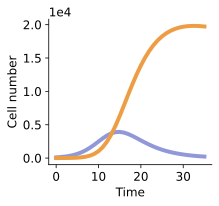

In [10]:
p, r, a, b, k, t0, d = (0.6, 0.4, 0.9, 0.1, 0.3, 12, 0.01)
fig, ax = plt.subplots(figsize=(3.2, 3))
K = 35
t = range(K)
x0 = [100, 0]
sol = solve_ivp(spx.sim_tissue.cellnumber, t_span=(0, K), y0=x0, t_eval=range(K+1),
                method='RK45', args=(a, b, k, t0, p, r, d))

ax.plot(sol.t, sol.y[0], label='Stem cells', c='#9098d9', lw=4)
ax.plot(sol.t, sol.y[1], label='Non-stem cells', c='#ed9e44', lw=4)
# ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Cell number')
ax.ticklabel_format (style='sci', scilimits= (-1,2), axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

In [13]:
mu = 2
for n in range(10):
    system = spx.sim_tissue.simulation(x0, K, mu, a, b, p, r, k, d, t0)
    data = {
                'SC':system.Stemcells, 
                'DC':system.Diffcells,
                'cell_num':np.hstack([np.array(system.t).reshape(-1,1), np.array(system.n)]),
            }
    pickle.dump(data, gzip.open(f'datasets/cellnumber_sample/{d=}_{p=}_{r=}_{a=}_{b=}_{k=}_{t0=}_{n}.pkl.gz', 'wb'))

cell_num:23768, time:35.0024444744394646

In [18]:
f = open('./datasets/cellnumber_sample/computational_times.txt', 'w')
f.write(f'CellNumb\tMutRateEst\tPhyloEst\n')
for i in os.listdir('./datasets/cellnumber_sample/'):
    if not i[-2:] == 'gz':
        continue
    data = pickle.load(gzip.open(f'datasets/cellnumber_sample/{i}', 'rb'))
    seqtab = np.array([i.seq for i in data['SC']] + [i.seq for i in data['DC']])
    seqtab = seqtab[np.random.choice(range(seqtab.shape[0]), 500, replace=False)]
    time0 = time()
    branch_len = spx.data_factory.get_branchlen(seqtab)
    mutnum = spx.data_factory.get_mutnum(seqtab)
    ge = spx.est_mr.GenerationEst(mutnum, 2)
    gen_num = ge.estimate(data['cell_num'][-1].sum())
    idata_bl = spx.est_mr.mutation_rate_mcmc(branch_len, draw=500, tune=500)
    time1 = time()
    pickle.dump(idata_bl, gzip.open(f"datasets/cellnumber_sample/{i.replace('.pkl.gz', '_idata_bl.pkl')}", 'wb'))
    time2 = time()
    ge = spx.est_mr.GenerationEst(mutnum, 2)
    gen_num = ge.estimate(data['cell_num'][-1].sum())
    for formula in i.split('_')[:-1]:
        exec(formula)
    ax = a*(1+p)
    bx = b*(1+p)+1-p
    axh, bxh, rh, dh, kh, t0h, dh = (ax,bx,r,d,k,t0, d)
    mcmc_prior = (axh, bxh, rh, dh, kh, t0h)
    idata = spx.est_tissue.mcmc_inference(gen_num, mcmc_prior, T=35, c0=100, sigma=100)
    time3 = time()
    pickle.dump(idata, gzip.open(f"datasets/cellnumber_sample/{i.replace('.pkl.gz', '_idata_mn.pkl')}", 'wb'))
    f.write(f'500\t{time1-time0}\t{time3-time2}\n')
f.close()

100%|██████████| 125250/125250 [00:03<00:00, 33096.46it/s]
Population sampling (4 chains)
DEMetropolis: [mu, delta]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 87 seconds.
/home/wangkun/miniconda3/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Population sampling (8 chains)
DEMetropolis: [ax, bx, r, k, t0, d]
Att

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 363 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 125250/125250 [00:03<00:00, 41205.09it/s]
Population sampling (4 chains)
DEMetropolis: [mu, delta]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 92 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Population sampling (8 chains)
DEMetropolis: [ax, bx, r, k, t0, d]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 327 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 125250/125250 [00:03<00:00, 32575.39it/s]
Population sampling (4 chains)
DEMetropolis: [mu, delta]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 93 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Population sampling (8 chains)
DEMetropolis: [ax, bx, r, k, t0, d]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 387 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 125250/125250 [00:03<00:00, 35193.44it/s]
Population sampling (4 chains)
DEMetropolis: [mu, delta]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 81 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Population sampling (8 chains)
DEMetropolis: [ax, bx, r, k, t0, d]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 384 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 125250/125250 [00:03<00:00, 35128.63it/s]
Population sampling (4 chains)
DEMetropolis: [mu, delta]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 89 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Population sampling (8 chains)
DEMetropolis: [ax, bx, r, k, t0, d]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 94 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 125250/125250 [00:03<00:00, 40671.71it/s]
Population sampling (4 chains)
DEMetropolis: [mu, delta]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 93 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Population sampling (8 chains)
DEMetropolis: [ax, bx, r, k, t0, d]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 355 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 125250/125250 [00:03<00:00, 33402.53it/s]
Population sampling (4 chains)
DEMetropolis: [mu, delta]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Population sampling (8 chains)
DEMetropolis: [ax, bx, r, k, t0, d]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 348 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 125250/125250 [00:03<00:00, 37063.00it/s]
Population sampling (4 chains)
DEMetropolis: [mu, delta]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 65 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Population sampling (8 chains)
DEMetropolis: [ax, bx, r, k, t0, d]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 331 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 125250/125250 [00:03<00:00, 37938.20it/s]
Population sampling (4 chains)
DEMetropolis: [mu, delta]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 82 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Population sampling (8 chains)
DEMetropolis: [ax, bx, r, k, t0, d]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 332 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 125250/125250 [00:03<00:00, 41073.46it/s]
Population sampling (4 chains)
DEMetropolis: [mu, delta]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 82 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Population sampling (8 chains)
DEMetropolis: [ax, bx, r, k, t0, d]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 344 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


EOFError: Ran out of input

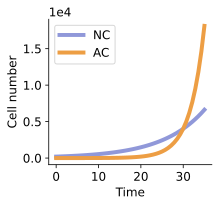

In [35]:
r, a, s, u = (0.5, 0.6, 0.2, 1e-3)
K = 35
x0 = [200, 0]
mut_rate = 2
sol = solve_ivp(spx.est_tumor.cellnumber, t_span=(0, K+1), y0=x0, 
                method='RK45', t_eval=np.linspace(0, K, 50), args=(r, a, s, u))
fig, ax = plt.subplots(1, 1, figsize=(3.2, 3))
ax.plot(sol.t, sol.y[0], label='NC', c='#9098d9', lw=4)
ax.plot(sol.t, sol.y[1], label='AC', c='#ed9e44', lw=4)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Cell number')
ax.ticklabel_format (style='sci', scilimits= (-1,2), axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

In [38]:
mu = 2
for n in range(10):
    system = spx.sim_tumor.simulation(x0, K, mu, r, a, s, u)
    data = {
                'NC':system.Neutral, 
                'AC':system.Advantageous,
                'cell_num':np.hstack([np.array(system.t).reshape(-1,1), np.array(system.n)]),
            }
    pickle.dump(data, gzip.open(f'datasets/cellnumber_sample1/{r=}_{a=}_{s=}_{u=}_{n}.pkl.gz', 'wb'))

cell_num:17459, time:35.0000076170801146